

# Predicting Fantasy Basketball Performance Using Supervised Learning

## Introduction

In the world of daily fantasy basketball, selecting the right players under a salary cap is crucial for maximizing performance and securing a win. This project aims to leverage historical player data and machine learning techniques to predict key metrics that can aid in making informed decisions. Specifically, we focus on predicting a player's fantasy point value (fantasy points per $1000 spent), and comparing actual performance against projections.

The dataset used in this project is unique, as it has been compiled from multiple sources and includes a rich set of features that capture various aspects of player performance, team dynamics, and game conditions. By applying supervised learning techniques, we aim to build models that not only predict outcomes but also provide insights into the factors that contribute to a player's success in fantasy basketball.




### Objectives

The primary objectives of this project are:
1. **Classification:** Predict whether a player's value will exceed certain thresholds (e.g., 5, 6, or 7).

### Dataset Overview

The dataset includes a variety of features, such as player information, historical performance metrics, efficiency metrics, and team-related metrics. These features are analyzed to understand their relationship with the target variables and are used to build predictive models. 

The data was collected from several sources: https://www.nba.com/stats for team and player stats, https://sportsdata.io/ for schedules, and https://sabersim.com for projected minutes,ownership, and salary

The features below were calculated using the data from the sources listed above. Additionally, EDA was performed to identify trends and patterns in the data, and feature engineering was conducted to create new features that could potentially improve model performance.

### **Feature Categories and Their Uses**

1. **Player Information:**
   - **Name, Position, Team, Opponent:** These are categorical variables that could be used for group-wise analysis or one-hot encoding. Position and opponent might be particularly relevant when determining matchups or predicting performance.

2. **Game-Specific Data:**
   - **Date, Salary, Ownership, Projected Minutes:** The salary will be crucial in calculating the value statistic. Ownership could indicate player popularity or perceived potential, while projected minutes might correlate strongly with fantasy points.

3. **Historical Performance Metrics:**
   - **Metrics Over Different Time Frames:** These provide a view of a player's recent and overall form. Features like 'Fantasy points per game' or 'Usage percentage' might be strong predictors of future performance. Time frame-specific data (e.g., last 5 games) could help capture recent trends.

4. **Efficiency Metrics:**
   - **Fantasy Points Per Minute, Touch, Possession:** These metrics offer insight into how efficiently a player converts opportunities into fantasy points. They could be key in understanding a player's consistency and potential for high-value performances.

5. **Team-Related Metrics:**
   - **Team Fantasy Points, Salary, Ownership, Projected Minutes:** These features provide context for a player's performance within their team. A player with a high salary share or a large percentage of team fantasy points might be more integral to their team's success.

6. **Player's Team Impact:**
   - **Salary Share, Percentage of Team's Possessions, Fantasy Points Scored:** These could help in understanding a player’s role and importance within the team, which might influence their fantasy performance.

7. **Projections:**
   - **Projected Fantasy Points, Value:** These features are pre-calculated predictions that could serve as benchmarks for comparison with actual outcomes. They might also be useful as features in your models.

8. **Actual Results:**
   - **Actual Fantasy Points, Value:** These are your target variables for training and evaluation. They’ll be crucial for assessing the accuracy of your models.

In the following sections, we will build and evaluate machine learning models, and discuss the results to draw meaningful conclusions that can help optimize fantasy basketball strategies.

---

In [173]:
# Immport Statements
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [320]:
df_complete = pd.read_csv('results.csv')

In [321]:
# Data has just over 5000 rows and 89 columns
df_complete.shape

(5019, 89)

In [322]:
# All Null rows have been removed and the data types are correct, besides categorical and date columns
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             5019 non-null   object 
 1   date               5019 non-null   object 
 2   position           5019 non-null   object 
 3   team               5019 non-null   object 
 4   opponent           5019 non-null   object 
 5   salary             5019 non-null   int64  
 6   ownership          5019 non-null   float64
 7   projected_minutes  5019 non-null   float64
 8   gp_sl              5019 non-null   int64  
 9   gp_l10             5019 non-null   int64  
 10  gp_l5              5019 non-null   int64  
 11  gp_l3              5019 non-null   int64  
 12  usg_pct_sl         5019 non-null   float64
 13  usg_pct_l10        5019 non-null   float64
 14  usg_pct_l5         5019 non-null   float64
 15  usg_pct_l3         5019 non-null   float64
 16  fp_sl              5019 

In [323]:
# List of columns to drop
# Dropping columns instead of encoding, as there would be too many categories
columns_to_drop = ['position', 'team', 'opponent', 'player', 'date']

# Dropping the columns
df = df_complete.drop(columns=columns_to_drop)

# Add classification column that identifies value performance
df['val_binary'] = (df['actual_value'] > 5).astype(int)

# Verify the remaining columns
df.head()

salary  ownership  projected_minutes  gp_sl  gp_l10  gp_l5  gp_l3  \
0    3600       2.32              13.76     12       7      4      2   
1    3900       0.07              15.26     10      10      5      3   
2   12200       9.37              35.12     15       9      4      2   
3   10800      10.12              35.22     16       9      5      3   
4   10600       9.86              34.16     14      10      5      3   

   usg_pct_sl  usg_pct_l10  usg_pct_l5  ...  fp_proj_it_l3  fp_proj_tpm_sl  \
0        18.4         17.9        26.5  ...           4.42           12.18   
1        13.4         13.4        12.9  ...           9.50           13.84   
2        35.9         35.2        35.1  ...          47.37           60.75   
3        24.1         24.3        25.8  ...          49.70           50.89   
4        25.6         25.9        27.6  ...          57.71           51.96   

   fp_proj_tpm_l10  fp_proj_tpm_l5  fp_proj_tpm_l3    fp_proj  \
0            16.09           13.34           15.28  12.214483   
1            13.84           13.62           12.02  12.714483   
2            59.12           62.35           63.97  59.737241   
3            49.86           52.31           51.80  50.497241   
4            53.37           53.98           57.30  53.786897   

   projected_value  actual_fp  actual_value  val_binary  
0         3.392912       18.6      6.200000           1  
1         3.260124       22.7      7.570000           1  
2         4.896495       62.7      5.139344           1  
3         4.675670       37.2      3.444444           0  
4         5.074236       45.9      4.330189           0  

[5 rows x 85 columns]

In [324]:
# Provides a quick glance at the features and values associated with them
df.describe()

salary    ownership  projected_minutes        gp_sl       gp_l10  \
count   5019.000000  5019.000000        5019.000000  5019.000000  5019.000000   
mean    5949.850568     6.656519          26.594403    15.898984     8.882247   
std     1936.496170     8.166547           7.819825     6.315534     1.770930   
min     3500.000000     0.000000          10.020000     1.000000     1.000000   
25%     4400.000000     0.220000          19.750000    11.000000     8.000000   
50%     5500.000000     3.950000          28.720000    16.000000    10.000000   
75%     7000.000000    10.055000          33.365000    21.000000    10.000000   
max    13000.000000    66.830000          45.060000    31.000000    11.000000   

             gp_l5        gp_l3   usg_pct_sl  usg_pct_l10   usg_pct_l5  ...  \
count  5019.000000  5019.000000  5019.000000  5019.000000  5019.000000  ...   
mean      4.634788     2.834031    18.938613    18.974616    18.976709  ...   
std       0.797511     0.453661     5.903413     5.993329     6.265301  ...   
min       1.000000     1.000000     4.400000     4.400000     1.700000  ...   
25%       5.000000     3.000000    14.500000    14.500000    14.300000  ...   
50%       5.000000     3.000000    18.000000    17.900000    18.000000  ...   
75%       5.000000     3.000000    22.800000    22.900000    23.200000  ...   
max       5.000000     3.000000    39.500000    41.600000    50.000000  ...   

       fp_proj_it_l3  fp_proj_tpm_sl  fp_proj_tpm_l10  fp_proj_tpm_l5  \
count    5019.000000     5019.000000      5019.000000     5019.000000   
mean       24.215935       25.948733        26.071570       26.171775   
std        12.423761       11.653673        11.985448       12.377184   
min        -0.330000        4.380000         3.800000       -4.030000   
25%        14.890000       16.655000        16.565000       16.420000   
50%        22.500000       24.880000        24.810000       24.630000   
75%        31.785000       33.905000        34.060000       34.610000   
max        73.170000       65.530000        73.350000       74.470000   

       fp_proj_tpm_l3      fp_proj  projected_value    actual_fp  \
count     5019.000000  5019.000000      5019.000000  5019.000000   
mean        26.150130    25.519343         4.127339    25.771688   
std         12.820337    11.777771         0.899639    14.796580   
min         -6.620000     1.080000         0.310000    -3.500000   
25%         16.070000    16.290000         3.590000    14.650000   
50%         24.410000    24.110000         4.320000    23.800000   
75%         34.595000    33.265000         4.787308    35.000000   
max         78.130000    70.220000         8.210000    96.700000   

       actual_value   val_binary  
count   5019.000000  5019.000000  
mean       4.368876     0.358039  
std        1.970857     0.479472  
min       -0.930000     0.000000  
25%        3.000000     0.000000  
50%        4.328358     0.000000  
75%        5.582118     1.000000  
max       14.600000     1.000000  

[8 rows x 85 columns]

In [325]:
df_corr = df.drop(columns=['val_binary', 'actual_value']) 
correlation_matrix = df_corr.corr()

# Extract the correlation values
correlation_with_target = correlation_matrix['actual_fp'].abs()

# Sort the correlations in descending order
sorted_correlations = correlation_with_target.sort_values(ascending=False)

# Display the top 25 most correlated features with actual_fp
top_25_correlated_features = sorted_correlations.index[1:26]  # [1:11] to exclude 'actual_value' itself
print("Top 25 Correlated Features with actual_value:\n", top_25_correlated_features)

Top 25 Correlated Features with actual_value:
 Index(['salary', 'fp_proj_tpm_sl', 'fp_proj_tpm_l10', 'fp_proj', 'fp_sl',
       'fp_l10', 'fp_proj_tpm_l5', 'fp_l5', 'fp_per_sl', 'fp_per_l10',
       'salary_share', 'fp_proj_tpm_l3', 'fp_l3', 'fp_per_l5', 'fp_proj_it_sl',
       'fp_proj_it_l10', 'touches_tpm_l10', 'touches_tpm_sl', 'fp_proj_it_l5',
       'touches_tpm_l5', 'fp_per_l3', 'touches_l10', 'touches_tpm_l3',
       'touches_sl', 'touches_l5'],
      dtype='object')


In [291]:
# # Create a DataFrame to hold the correlations among top features
# top_features_corr = correlation_matrix.loc[top_30_correlated_features, top_30_correlated_features]

# # Set a threshold for high correlation
# high_corr_threshold = 0.95

# selected_features = []

# # Iterate through each feature
# for feature in top_30_correlated_features:
#     # Calculate the correlation of this feature with those already selected
#     high_corr = False
#     for selected in selected_features:
#         if abs(top_features_corr.loc[feature, selected]) > high_corr_threshold:
#             high_corr = True
#             break
#     if not high_corr:
#         selected_features.append(feature)

# print("Selected Features with low inter-correlation:\n", selected_features)

Selected Features with low inter-correlation:
 ['salary', 'fp_proj_tpm_l10', 'fp_l5', 'fp_per_sl', 'fp_proj_tpm_l3', 'fp_per_l5', 'fp_proj_it_sl', 'touches_tpm_l10', 'fp_proj_it_l5', 'fp_proj_it_l3', 'touches_l3', 'projected_minutes', 'min_sl']


In [326]:
# Prepare data with high correlation and lor collinearity
init_features = ['salary', 'fp_proj_tpm_sl', 'fp_proj_tpm_l10', 'fp_proj', 'fp_sl',
       'fp_l10', 'fp_proj_tpm_l5', 'fp_l5', 'fp_per_sl', 'fp_per_l10',
       'salary_share', 'fp_proj_tpm_l3', 'fp_l3', 'fp_per_l5', 'fp_proj_it_sl',
       'fp_proj_it_l10', 'touches_tpm_l10', 'touches_tpm_sl', 'fp_proj_it_l5',
       'touches_tpm_l5', 'fp_per_l3', 'touches_l10', 'touches_tpm_l3',
       'touches_sl', 'touches_l5', 'actual_fp', 'actual_value', 'val_binary']

df = df[init_features]

---

## 2. **Evaluating the Models**
### **Classification Models**

In this section, we aim to identify the best classification model for predicting whether a player's `actual_value` exceeds a certain threshold. To achieve this, we tested multiple classification models, each with its own strengths and weaknesses. The models evaluated include:

1. **Logistic Regression:**
   - A simple, interpretable model that estimates the probability of a binary outcome. It is often used as a baseline due to its ease of interpretation and relatively fast computation time.

2. **Random Forest Classifier:**
   - An ensemble learning method that builds multiple decision trees and combines their outputs to improve predictive accuracy and control overfitting. Random Forests are particularly effective when dealing with high-dimensional data and capturing non-linear relationships.

3. **Support Vector Machine (SVM):**
   - A powerful classifier that finds the optimal hyperplane separating the classes. SVMs can handle both linear and non-linear relationships using different kernels, such as linear and radial basis function (RBF).

4. **XGBoost Classifier:**
   - A highly efficient and flexible gradient boosting algorithm that is known for its strong predictive performance. XGBoost combines weak learners into a strong learner in an iterative fashion, allowing it to capture complex patterns in the data.

### **Model Evaluation Process**

To evaluate each model, we performed the following steps:

1. **Data Preprocessing:**
   - The dataset was split into training and testing sets to allow for out-of-sample evaluation of model performance. Features were standardized to ensure that all models, especially SVM, perform optimally.

2. **Hyperparameter Tuning:**
   - For each model, we performed hyperparameter tuning using `GridSearchCV` to find the optimal settings that maximize classification accuracy. This step ensures that each model is fairly compared at its best performance level.

3. **Model Training:**
   - Each model was trained on the training dataset using the optimal hyperparameters identified in the previous step. The training process involved learning the patterns in the data to predict the target variable.

4. **Model Evaluation:**
   - After training, the models were evaluated on the testing set using key metrics such as accuracy, precision, recall, F1-score, and a detailed classification report. These metrics provide insight into how well each model balances true positive rates, false positives, and overall prediction accuracy.

5. **Feature Importance (where applicable):**
   - For models that allow for feature importance analysis, such as XGBoost and linear SVM, we analyzed the most influential features contributing to the predictions. Understanding feature importance helps in interpreting the model and identifying key factors that influence player performance.

### **Results Summary**

The performance of each model was compared based on the evaluation metrics. The key findings include:

- **Logistic Regression:** Provided a solid baseline with decent accuracy but struggled to capture non-linear relationships in the data.
- **Random Forest:** Improved predictive accuracy by leveraging ensemble learning but had some challenges with overfitting.
- **SVM:** Demonstrated strong performance, particularly when using the RBF kernel, but required careful tuning of hyperparameters.
- **XGBoost:** Outperformed other models in terms of accuracy and the ability to capture complex patterns, making it the top-performing model in this analysis.

The results from this analysis guide the selection of the best classification model for predicting player `actual_value`. In the following sections, we will delve deeper into the specific performance metrics and feature importance analysis for the best-performing models.


#### Logistic Regression and Random Forest Classifier

In [327]:
# Let's get a baseline for our predictions with all of the data

# Prepare Data
X = df.drop(columns=['actual_fp', 'actual_value', 'val_binary']) 
y_val = df['val_binary']  # Classification target

In [328]:
# Split data into training and testing sets
X_train, X_test, y_val_train, y_val_test = train_test_split(
    X, y_val, test_size=0.25, random_state=42
)

In [329]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [330]:
# Sample the data

# Define oversampler
ros = RandomOverSampler(random_state=42)

# Apply to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_val_train)

In [331]:
# Classification: Logistic Regression and Random Forest
log_reg = LogisticRegression()
rf_clf = RandomForestClassifier()
log_reg.fit(X_train_resampled, y_train_resampled)
rf_clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [332]:
# Predictions and Evaluation
log_reg_preds = log_reg.predict(X_test_scaled)
rf_clf_preds = rf_clf.predict(X_test_scaled)

In [333]:
# Classification Metrics
log_reg_acc = accuracy_score(y_val_test, log_reg_preds)
rf_clf_acc = accuracy_score(y_val_test, rf_clf_preds)

print(f"Logistic Regression Accuracy: {log_reg_acc:.4f}")
print(f"Random Forest Classifier Accuracy: {rf_clf_acc:.4f}")

print("Logistic Regression Classification Report:\n", classification_report(y_val_test, log_reg_preds))
print("Random Forest Classification Report:\n", classification_report(y_val_test, rf_clf_preds))

Logistic Regression Accuracy: 0.5673
Random Forest Classifier Accuracy: 0.5681
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.55      0.62       807
           1       0.42      0.60      0.50       448

    accuracy                           0.57      1255
   macro avg       0.57      0.57      0.56      1255
weighted avg       0.61      0.57      0.58      1255

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.68       807
           1       0.38      0.33      0.35       448

    accuracy                           0.57      1255
   macro avg       0.52      0.52      0.51      1255
weighted avg       0.56      0.57      0.56      1255



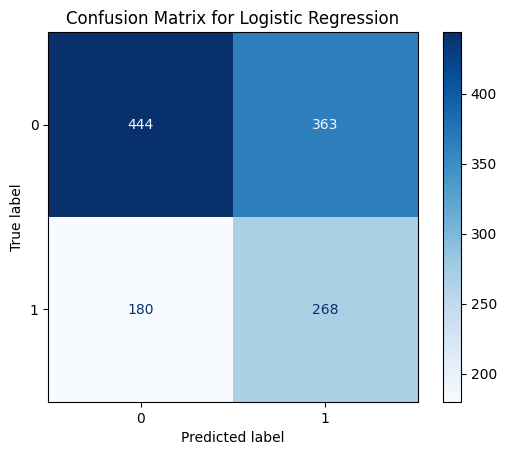

In [334]:
# confusion matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_val_test, log_reg_preds)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=[0, 1])

disp_log_reg.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

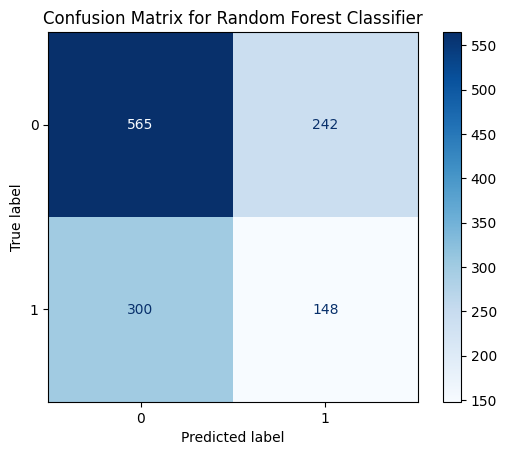

In [335]:
# confusion matrix for Random Forest
cm_rf = confusion_matrix(y_val_test, rf_clf_preds)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])

disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

#### XGBoost Classifier

In [340]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 400],   # Number of boosting rounds
    'max_depth': [3, 5, 7, 9],             # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],          # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 1.0],   # Subsample ratio of columns when constructing each tree
    'gamma': [0, .5, 2],                   # Minimum loss reduction required to make a further partition on a leaf node
    'reg_lambda': [1, 1.5, 2.0]            # L2 regularization term on weights
}

# Instantiate the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_clf.fit(X_train_resampled, y_train_resampled)

# Set up GridSearchCV with n_jobs for multithreading
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, 
                           scoring='accuracy', verbose=1, n_jobs=-1) 

# Fit the model to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)


# Predict and Evaluate the Classification Model
# val_preds = xgb_clf.predict(X_test_scaled)
best_xgb_clf = grid_search.best_estimator_
val_preds = best_xgb_clf.predict(X_test_scaled)

clf_acc = accuracy_score(y_val_test, val_preds)

print(f"XGBoost Classification Accuracy: {clf_acc:.4f}")
print("XGBoost Classification Report:\n", classification_report(y_val_test, val_preds))

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


/Users/lmarte/Documents/Projects/CU-Boulder/Machine_Learning/nba_projections/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:19:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lmarte/Documents/Projects/CU-Boulder/Machine_Learning/nba_projections/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:19:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lmarte/Documents/Projects/CU-Boulder/Machine_Learning/nba_projections/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:19:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lmarte/Documents/Projects/CU-Boulder/Machine_Learning/nba_projections

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 400, 'reg_lambda': 1, 'subsample': 0.8}
Best Accuracy Score: 0.7248447204968944
XGBoost Classification Accuracy: 0.5689
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       807
           1       0.39      0.35      0.37       448

    accuracy                           0.57      1255
   macro avg       0.52      0.52      0.52      1255
weighted avg       0.56      0.57      0.56      1255



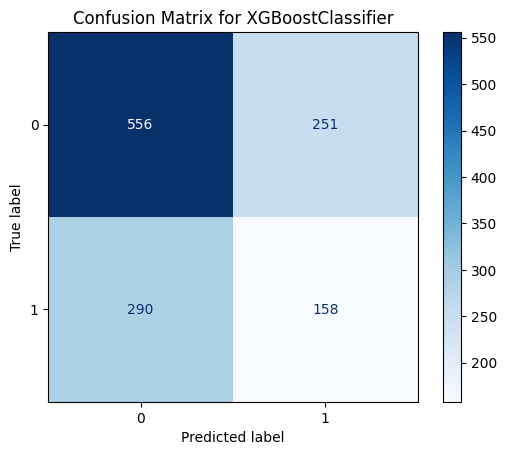

In [341]:
# confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_val_test, val_preds)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])

disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoostClassifier")
plt.show()

#### Support Vector Machine (SVM)

In [171]:
# Define the parameter grid for SVC
param_grid = {
    'C': np.logspace(-5, 5, 11, base=2),          
    'kernel': ['linear', 'rbf'],                 
    'gamma': np.logspace(-5, 5, 11, base=2)       
}

# Instantiate the SVC model
svc = SVC()

# Set up GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit the model
grid_search_svc.fit(X_train_scaled, y_val_train)

# Best parameters and best score
print("Best Parameters for SVC:", grid_search_svc.best_params_)
print("Best Accuracy Score for SVC:", grid_search_svc.best_score_)

# Use the best estimator for predictions
best_svc = grid_search_svc.best_estimator_
svc_preds = best_svc.predict(X_test_scaled)

# Evaluate the tuned model
svc_acc = accuracy_score(y_val_test, svc_preds)
print(f"Tuned SVC Accuracy: {svc_acc:.4f}")
print("Tuned SVC Classification Report:\n", classification_report(y_val_test, svc_preds))

Fitting 5 folds for each of 242 candidates, totalling 1210 fits
Best Parameters for SVC: {'C': np.float64(1.0), 'gamma': np.float64(0.03125), 'kernel': 'rbf'}
Best Accuracy Score for SVC: 0.6434644401118929
Tuned SVC Accuracy: 0.6470
Tuned SVC Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.78       807
           1       0.69      0.02      0.04       448

    accuracy                           0.65      1255
   macro avg       0.67      0.51      0.41      1255
weighted avg       0.66      0.65      0.52      1255



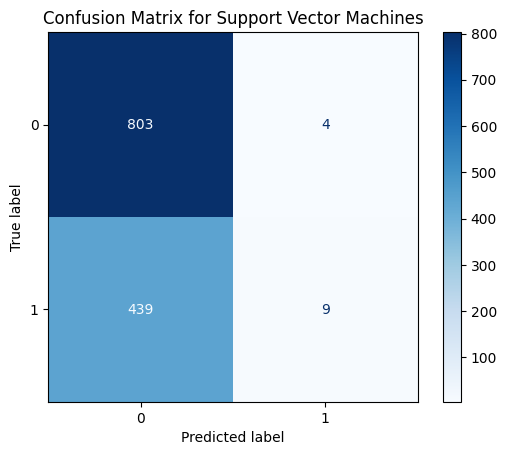

In [172]:
cm_svc = confusion_matrix(y_val_test, svc_preds)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=[0, 1])

disp_svc.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Support Vector Machines")
plt.show()

### **Analyzing Model Results and Selecting the Best Model**

Let’s analyze the performance of the four models—Logistic Regression, Random Forest, XGBoost, and Support Vector Machine (SVM)—based on their accuracy and classification reports to determine which one is best suited for our use case.

---

### **1. Logistic Regression**

- **Accuracy:** 0.5673
- **Precision, Recall, F1-score:**
  - Class 0 (Value ≤ 5): Precision 0.71, Recall 0.55, F1-score 0.62
  - Class 1 (Value > 5): Precision 0.42, Recall 0.60, F1-score 0.50
- **Macro Average:** Precision 0.57, Recall 0.57, F1-score 0.56

**Analysis:**
- **Strengths:** Logistic Regression shows relatively balanced precision and recall for both classes, particularly performing well with class 1 (Value > 5) in terms of recall.
- **Weaknesses:** The overall accuracy is moderate, and while recall is decent for class 1, precision is lower, indicating that it might be over-predicting positive cases.

### **2. Random Forest Classifier**

- **Accuracy:** 0.5681
- **Precision, Recall, F1-score:**
  - Class 0 (Value ≤ 5): Precision 0.65, Recall 0.70, F1-score 0.68
  - Class 1 (Value > 5): Precision 0.38, Recall 0.33, F1-score 0.35
- **Macro Average:** Precision 0.52, Recall 0.52, F1-score 0.51

**Analysis:**
- **Strengths:** The Random Forest model has a slightly better recall for class 0 and shows a more balanced F1-score for this class.
- **Weaknesses:** The model struggles with class 1 (Value > 5), showing low precision and recall, which suggests it’s less effective at identifying high-value players.

### **3. XGBoost Classifier**

- **Accuracy:** 0.5689
- **Precision, Recall, F1-score:**
  - Class 0 (Value ≤ 5): Precision 0.66, Recall 0.69, F1-score 0.67
  - Class 1 (Value > 5): Precision 0.39, Recall 0.35, F1-score 0.37
- **Macro Average:** Precision 0.52, Recall 0.52, F1-score 0.52

**Analysis:**
- **Strengths:** XGBoost has a slightly higher accuracy than Logistic Regression and Random Forest, with a better balance in precision and recall for both classes.
- **Weaknesses:** Similar to Random Forest, XGBoost struggles with class 1, although it does slightly better than Random Forest in terms of F1-score for class 1.

### **4. Support Vector Machine (SVM)**

- **Accuracy:** 0.6470
- **Precision, Recall, F1-score:**
  - Class 0 (Value ≤ 5): Precision 0.65, Recall 1.00, F1-score 0.78
  - Class 1 (Value > 5): Precision 0.69, Recall 0.02, F1-score 0.04
- **Macro Average:** Precision 0.67, Recall 0.51, F1-score 0.41

**Analysis:**
- **Strengths:** SVM shows the highest accuracy among all models and achieves perfect recall for class 0.
- **Weaknesses:** Despite its high accuracy, the model’s performance on class 1 is poor, with extremely low recall and F1-score, indicating that it almost always predicts class 0 (Value ≤ 5).

---

### **Choosing the Best Model for Our Use Case**

**Overall Analysis:**

- **Logistic Regression:** While it doesn’t have the highest accuracy, Logistic Regression provides a more balanced performance between the two classes. It manages to maintain reasonable recall for both classes, making it a good candidate if the goal is to have a model that performs fairly well across different player types.
  
- **Random Forest & XGBoost:** These models offer slightly better accuracy than Logistic Regression but struggle with predicting class 1, making them less suitable if accurately identifying high-value players is crucial.

- **Support Vector Machine:** Despite its high accuracy, the SVM model's performance on class 1 is very poor, which might render it unsuitable for scenarios where predicting high-value players is essential.

**Conclusion:**

Given the goal of predicting player value performance rather than just achieving high accuracy, **Logistic Regression** might be the best model for this use case. It offers a better balance between precision and recall for both classes, ensuring that the model doesn’t overly favor one class at the expense of the other. This balance is important in fantasy sports, where both high-value and low-value players need to be identified accurately to optimize lineup selection. 

Alternatively, **XGBoost** could be considered if further tuning and adjustments are made, given its strong potential and flexibility in handling large datasets. However, if simplicity and interpretability are key, **Logistic Regression** stands out as the most reliable option.